In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
import matplotlib.pyplot as plt
import numpy as np

In [12]:
spitzer_time, spitzer_flux, spitzer_err, _ = np.loadtxt('T1_Spitzer.txt', unpack=True, delimiter=',')
spitzer_flux += 1
spitzer_time += 2457650

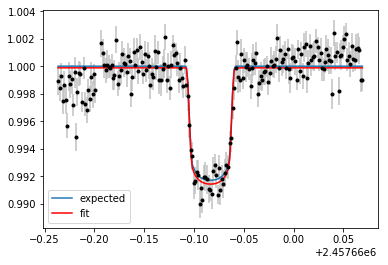

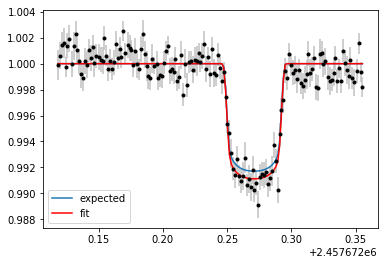

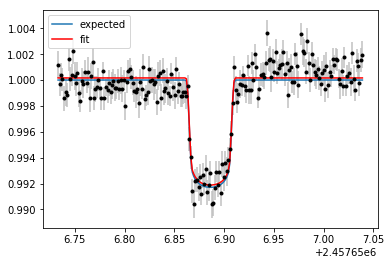

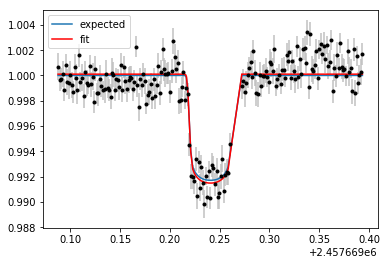

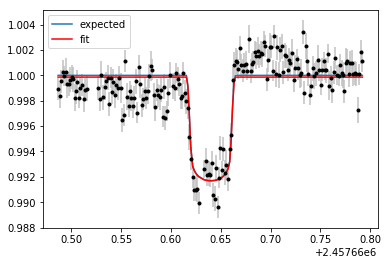

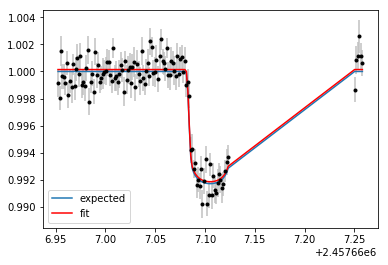

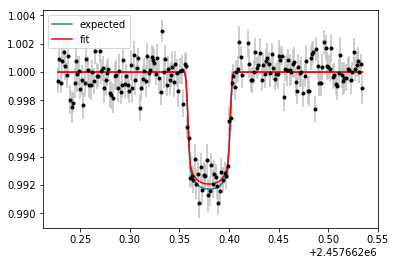

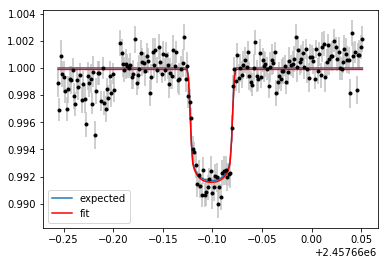

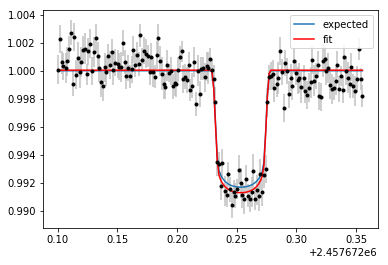

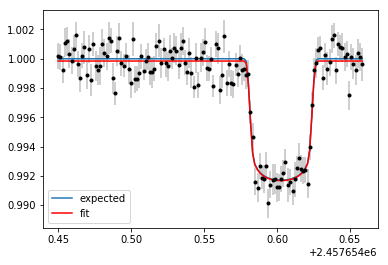

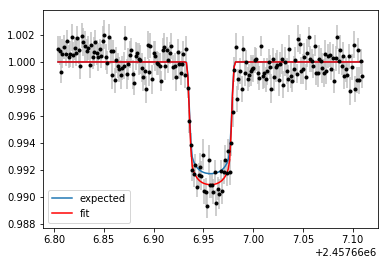

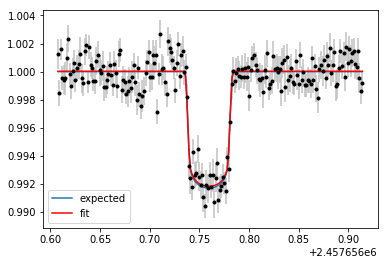

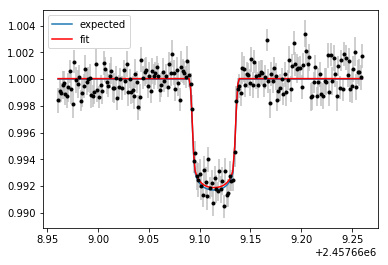

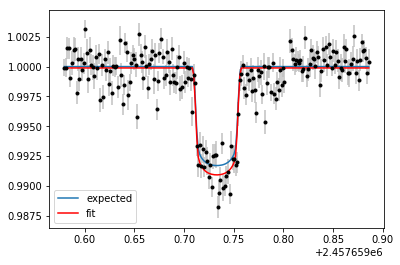

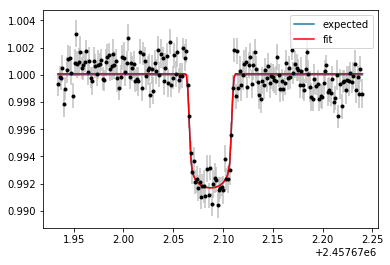

In [74]:
from toolkit import trappist1, transit_model, transit_duration
from scipy.signal import argrelmin
from copy import deepcopy
from scipy.optimize import fmin_l_bfgs_b

def depth_model(p, times, params):
    trial_params = deepcopy(params)
    amp, depth = p
    trial_params.rp = depth**0.5
    return amp * transit_model(times, trial_params)


def chi2(p, times, fluxes, errors, params):
    return np.sum((fluxes - depth_model(p, times, params))**2 / errors**2)

depths = []

counter = -1
for i in np.random.rand(1000):
    counter += 1
    g = trappist1('g')
    g.t0 += i * g.per
    duration = transit_duration(g)

    model = transit_model(spitzer_time, g)

    approx_midtransit_times = argrelmin(model)[0]

    injected_transits = spitzer_flux * model

    # plt.plot(spitzer_time, injected_transits, '.')
    # plt.axvline(spitzer_time[approx_midtransit_times[0]])
    # plt.axvline(spitzer_time[approx_midtransit_times[1]])

    for mt in approx_midtransit_times: 

        approx_midtransit = spitzer_time[mt]
        chunk = ((spitzer_time < approx_midtransit + 4*duration) & 
                 (spitzer_time > approx_midtransit - 4*duration))
        oot = model[chunk] == 1
        chunk_time = spitzer_time[chunk]
        chunk_flux = injected_transits[chunk] / np.median(injected_transits[chunk][oot])
        chunk_err = spitzer_err[chunk]
        
        result = fmin_l_bfgs_b(chi2, [1, g.rp**2], approx_grad=True, 
                               bounds=[(0.8, 1.2), (0.8*g.rp**2, 1.2*g.rp**2)],
                               args=(chunk_time, chunk_flux, chunk_err, g))[0]

        depths.append(result[1])
        
        if counter < 10:
            plt.figure()
            plt.errorbar(chunk_time, chunk_flux, chunk_err, fmt='.', color='k', ecolor='silver')
            plt.plot(chunk_time, transit_model(chunk_time, g), color='C0', label='expected')
            plt.plot(chunk_time, depth_model(result, chunk_time, g), color='r', label='fit')
            plt.legend()

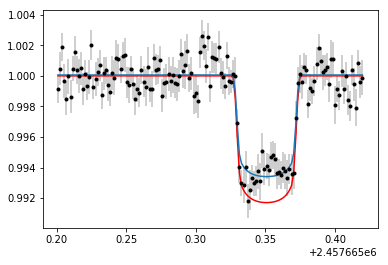

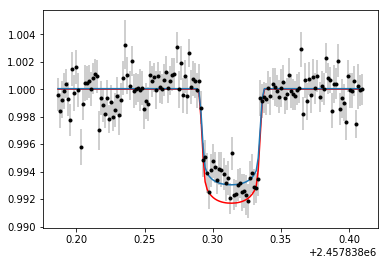

In [76]:
g = trappist1('g')

occultation_depths = []

for p in ['reduced_lcs/lightcurve_1.txt', 'reduced_lcs/lightcurve_4.txt']:
    bjd, flux, err = np.loadtxt(p, unpack=True)
    
    result = fmin_l_bfgs_b(chi2, [1, g.rp**2], approx_grad=True, 
                       bounds=[(0.8, 1.2), (0.8*g.rp**2, 1.2*g.rp**2)],
                       args=(bjd, flux, err, g))[0]
    occultation_depths.append(result[1])
    plt.figure()
    plt.errorbar(bjd, flux, err, fmt='.', color='k', ecolor='silver')
    plt.plot(bjd, transit_model(bjd, g), color='r', label='expected')
    plt.plot(bjd, depth_model(result, bjd, g), color='C0', label='fit')

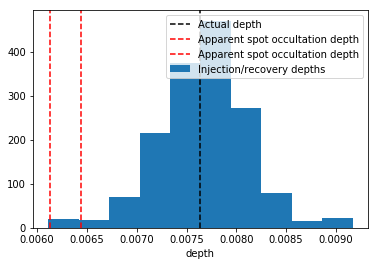

In [78]:
plt.hist(depths, label='Injection/recovery depths')
plt.axvline(g.rp**2, ls='--', color='k', label='Actual depth')

for d in occultation_depths:
    plt.axvline(d, ls='--', color='r', label='Apparent spot occultation depth')
plt.xlabel('depth')
plt.legend()
plt.savefig('injection_recovery.png', dpi=200, bbox_inches='tight')